In [1]:
from best.ltl import formula_to_mdp
from best.hVI_sample_map import SPaths
from best.hVI_models import State_Space, Det_SI_Model
from best.hVI_types import Env, Gamma
import best.rss18_functions as rf
from best.hVI_config import sc, load, parr, obs_action, epsilon, rand_seed
import numpy as np
from collections import OrderedDict
import matplotlib.pyplot as plt
import copy
import cPickle as pkl
import random
from os import fork
from joblib import Parallel, delayed
import multiprocessing
from itertools import product
import time

from polytope import *
%matplotlib inline

No handlers could be found for logger "polytope.solvers"


Setting Up Scenario
Started wall case
Regions: 
OrderedDict([('r4', 0), ('r9', 1), ('a1', 2)])

Total number of unknown regions: 3
Total number of  regions: 12
Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


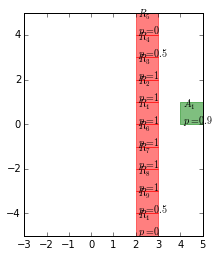

In [2]:

print "Setting Up Scenario"


# Define Regions
# Regs have the same format as RSS code. Regs that are added first have a higher priority
#### Wall region
print("Started wall case")
regs = OrderedDict()
p1 = rf.vertex_to_poly(np.array([[2, 0], [3, 0], [3, 1], [2, 1]]))
regs['r1'] = (p1, 1, 'obs')
p2 = rf.vertex_to_poly(np.array([[2, 1], [3, 1], [3, 2], [2, 2]]))
regs['r2'] = (p2, 1, 'obs')
p3 = rf.vertex_to_poly(np.array([[2, 2], [3, 2], [3, 3], [2, 3]]))
regs['r3'] = (p3, 1, 'obs')
p4 = rf.vertex_to_poly(np.array([[2, 3], [3, 3], [3, 4], [2, 4]]))
regs['r4'] = (p4, 0.5, 'obs', 0)
p5 = rf.vertex_to_poly(np.array([[2, 4], [3, 4], [3, 5], [2, 5]]))
regs['r5'] = (p5, 0.1, 'obs', 0)


p1 = rf.vertex_to_poly(np.array([[2, 0], [3, 0], [3, -1], [2, -1]]))
regs['r6'] = (p1, 1, 'obs')
p2 = rf.vertex_to_poly(np.array([[2, -1], [3, -1], [3, -2], [2, -2]]))
regs['r7'] = (p2, 1, 'obs')
p3 = rf.vertex_to_poly(np.array([[2, -2], [3, -2], [3, -3], [2, -3]]))
regs['r8'] = (p3, 1, 'obs')
p4 = rf.vertex_to_poly(np.array([[2, -3], [3, -3], [3, -4], [2, -4]]))
regs['r9'] = (p4, 0.5, 'obs', 0)
p5 = rf.vertex_to_poly(np.array([[2, -4], [3, -4], [3, -5], [2, -5]]))
regs['r10'] = (p5, 0.1, 'obs', 0)



a1 = rf.vertex_to_poly(np.array([[4, 0], [5, 0], [5, 1], [4, 1]]))
regs['a1'] = (a1, 0.9, 'sample', 1)


output_color = {'r1':'red', 'r2':'red', 'r3':'red', 'r4':'red', 'r5':'red','r6':'red','r7':'red',
                'r8':'red','r9':'red','r10':'red',
            'a1':'green',  'null':'white'}
# Define Null regions with bounds of the space for null output with lowest priority
p = rf.vertex_to_poly(np.array([[-3,-5],[-3,5],[5,-5],[5,5]]))
regs['null'] = (p, 1.0, 'null')

# Construct belief-MDP for env
env = Env(regs)

print(env)
# belief set used for PBVI =>>> unclear what this is
probs = [0, 0.2, 0.5, 0.8, 1] # what is this?
probs_list = [probs for i in range(env.n_unknown_regs)]
if obs_action is True:
    b_reg_set = [env.get_reg_belief(list(i)) for i in product(*probs_list)]
b_prod_set = [env.get_product_belief(list(i)) for i in product(*probs_list)]
# True state of the regs used to simulate trajectories after policy is generated
#x_e_true 


fig = plt.figure(0)
ax = fig.add_subplot(111, aspect='equal')
l,u = bounding_box(p)
ax.set_xlim(l[0], u[0])
ax.set_ylim(l[1], u[1])
for (name, info) in regs.iteritems():
    hatch = False
    fill = True
    if name is not 'null':
        rf.plot_region(ax, info[0], name, info[1], output_color[name], hatch=hatch, fill=fill)
# plt.show()

from matplotlib2tikz import save as tikz_save


tikz_save(
    'new_figure.tex',
    figureheight='\\figureheight',
    figurewidth='\\figurewidth'
    )



 Setup Motion and Observation Models 
 The used model contains an integrator for each dimension:

[[ 1.  0.]
 [ 0.  1.]]
 Constructing FIRM
[[ 1.  0.]
 [ 0.  1.]]
[[ 0.1  0. ]
 [ 0.   0.1]]
[[ 10.51249   0.     ]
 [  0.       10.51249]]
('remove edge', set([3, 36]))
set(['r4', 'null', 'r3'])
('remove edge', set([28, 5]))
set(['null', 'r10'])
('remove edge', set([28, 6]))
set(['null', 'r10'])
('remove edge', set([8, 28]))
set(['null', 'r9', 'r10'])
('remove edge', set([8, 37]))
set(['null', 'r8', 'r9'])
('remove edge', set([10, 34]))
set(['a1', 'null', 'r1'])
('remove edge', set([11, 36]))
set(['null', 'r1'])
('remove edge', set([20, 12]))
set(['r4', 'r5', 'null'])
('remove edge', set([34, 36]))
set(['null', 'r1'])
('remove edge', set([36, 37]))
set(['r6', 'null', 'r1'])
[ 0.01082  1.26949]


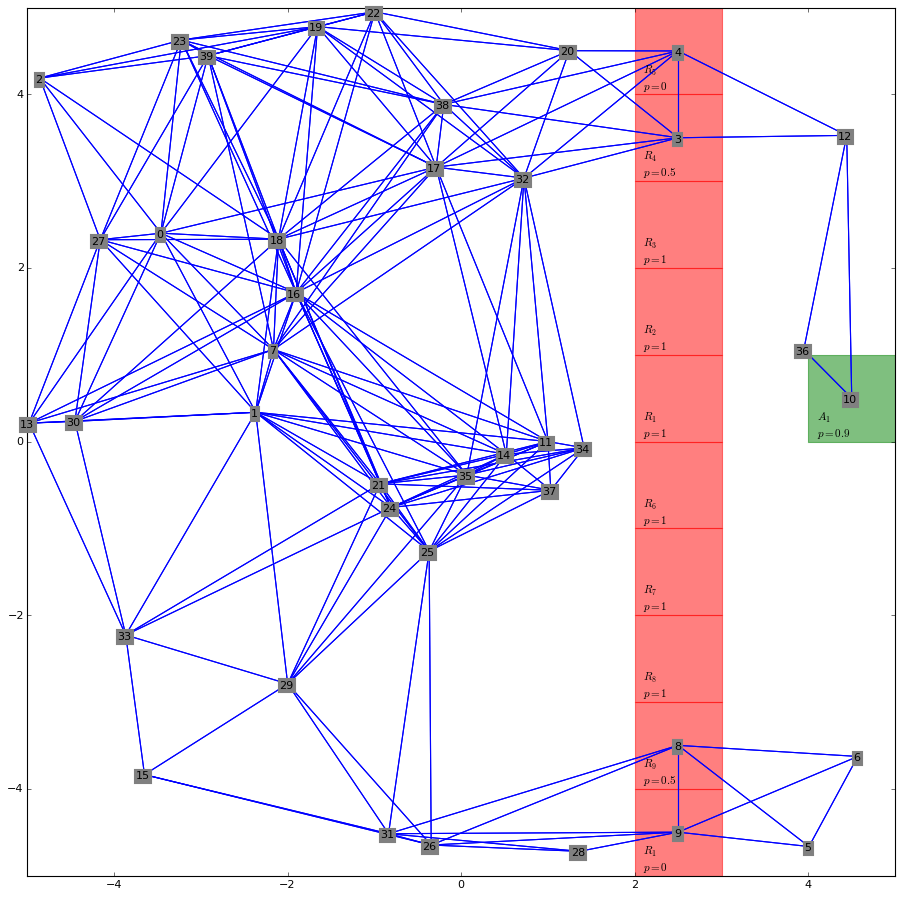

In [6]:

# Construct and Visualize FIRM

''' Configuration Parameters '''
random.seed(rand_seed)
np.random.seed(rand_seed)

print ''' Setup Motion and Observation Models '''
# Define Motion and Observation Model
Wx = np.eye(2)
Wu = np.eye(2)
r2_bs = State_Space([-5, -5], [5, 5])
motion_model = Det_SI_Model(0.1)

print " Constructing FIRM"
fig = fig=plt.figure(figsize=(14, 14), dpi= 80, facecolor='w', edgecolor='k')

ax = fig.add_subplot(111, aspect='equal')
firm = SPaths(r2_bs, motion_model, Wx, Wu, regs, output_color, ax)
firm.make_nodes_edges(40,3.5)
firm.compute_output_prob()
firm.plot(ax)


In [4]:

# Create DFA
formula = '! obs U sample'
dfsa, dfsa_init, dfsa_final, proplist = formula_to_mdp(formula)

def backup(i_b, i_v, i_q, val):
    b = val[i_v][i_q].b_prod_points[i_b]
    if i_q in dfsa_final:
        return (np.ones([len(b), 1]), firm.edges[i_v][0]) # return 0th edge caz it doesn't matter
    index_alpha_init = np.argmax(val[i_v][i_q].alpha_mat.T * b)  # set max alpha to current max
    max_alpha_b_e = val[i_v][i_q].alpha_mat[:, index_alpha_init]
    best_e = val[i_v][i_q].best_edge[index_alpha_init]
    for i_e in range(len(firm.edges[i_v])):
        p_outputs = firm.edge_output_prob[i_v][i_e]
        v_e = firm.edges[i_v][i_e]
        O = env.get_O_prod(firm.nodes[v_e].mean)
        sum_z = np.zeros([2**env.n_unknown_regs, 1])
        for z, info in firm.regs.iteritems():
            if p_outputs[z] == 0:
                continue
            sum_o = np.zeros([2**env.n_unknown_regs, 1])
            for i_o in range(len(O)):
                q_z_o = None
                # if we are in an obstacle region and we observe an obstacle/sample
                if regs[z][1]==1:
                    # if regs[z][2]=='obs' or regs[z][2]=='sample':
                    if regs[z][2]=='obs' or regs[z][2]=='sample' and regs[z][0].contains(firm.nodes[v_e].mean):
                        q_z_o = np.argmax(dfsa.T(proplist[regs[z][2]])[i_q, :])
                elif regs[z][1]>0:
                    # if (regs[z][2]=='obs' or regs[z][2]=='sample') and (env.x_e[i_o] & 2**env.reg_index[z] == 2**env.reg_index[z]):
                    if (regs[z][2]=='obs' or regs[z][2]=='sample') and (env.x_e[i_o] & 2**env.reg_index[z] == 2**env.reg_index[z]) and regs[z][0].contains(firm.nodes[v_e].mean):
                        q_z_o = np.argmax(dfsa.T(proplist[regs[z][2]])[i_q, :])
                if q_z_o is None:
                    q_z_o = i_q
                gamma_o_e = np.diag(np.ravel(O[i_o, :])) * np.matrix(val[v_e][q_z_o].alpha_mat)
                index = np.argmax(gamma_o_e.T * b)
                sum_o = sum_o + gamma_o_e[:, index]
                # if (i_v==8 and i_q==0 and (v_e==7) and i==3):
                    # print "obs = " + str(i_o) + "q_z_o = " + str(q_z_o)
                    # print sum_z.T * b
                    # print max_alpha_b_e.T * np.matrix(b)
                    # import pdb; pdb.set_trace()
            sum_z = sum_z + p_outputs[z] * sum_o
        if (max_alpha_b_e.T * np.matrix(b) + epsilon) < (sum_z.T * np.matrix(b)):
            max_alpha_b_e = sum_z
            best_e = firm.edges[i_v][i_e]
    return (max_alpha_b_e, best_e)


In [6]:

def backup_with_obs_action(i_b, i_v, i_q, val):
    b = val[i_v][i_q].b_prod_points[i_b]
    if i_q in dfsa_final:
        return (np.ones([len(b), 1]), firm.edges[i_v][0]) # return 0th edge caz it doesn't matter
    index_alpha_init = np.argmax(val[i_v][i_q].alpha_mat.T * b)  # set max alpha to current max
    max_alpha_b_e = val[i_v][i_q].alpha_mat[:, index_alpha_init]
    best_e = val[i_v][i_q].best_edge[index_alpha_init]
    # Foreach edge action
    for i_e in range(len(firm.edges[i_v])):
        p_outputs = firm.edge_output_prob[i_v][i_e]
        v_e = firm.edges[i_v][i_e]
        sum_z = np.zeros([2**env.n_unknown_regs, 1])
        for z, info in firm.regs.iteritems():
            if p_outputs[z] == 0:
                continue
            # if (i_v==0 and i_q==0 and i_b==31 and i==7):
                # print "obs = " + str(i_o) + "q_z_o = " + str(q_z_o)
                # print sum_z.T * b
                # print max_alpha_b_e.T * np.matrix(b)
                # import pdb; pdb.set_trace()
            # If we get a null output from an edge or region is known then don't sum over obs
            if regs[z][2] is 'null' or regs[z][1]==1 or regs[z][1]==0:
                if (regs[z][2]=='obs' or regs[z][2]=='sample') and regs[z][1]==1:
                    q_z_o = np.argmax(dfsa.T(proplist[regs[z][2]])[i_q, :])
                elif regs[z][2] is 'null' or regs[z][1]==0:
                    q_z_o = i_q
                gamma_e = np.matrix(val[v_e][q_z_o].alpha_mat)
                index = np.argmax(gamma_e.T * b)
                sum_o = gamma_e[:, index]
            else:
                sum_o = 0
                O = env.get_O_reg_prob(z)
                for i_o in range(2):
                    q_z_o = None
                    # if we pass through an unknown obstacle/sample region and also observe obstacle/sample
                    if regs[z][1]>0:
                        if (regs[z][2]=='obs' or regs[z][2]=='sample') and (i_o is 1):
                            q_z_o = np.argmax(dfsa.T(proplist[regs[z][2]])[i_q, :])
                    if q_z_o is None:
                        q_z_o = i_q
                    gamma_e = np.diag(np.ravel(O[i_o, :])) * np.matrix(val[v_e][q_z_o].alpha_mat)
                    index = np.argmax(gamma_e.T * b)
                    sum_o = sum_o + gamma_e[:, index]
            sum_z = sum_z + p_outputs[z] * sum_o
        if (max_alpha_b_e.T * np.matrix(b) + epsilon) < (sum_z.T * np.matrix(b)):
            max_alpha_b_e = sum_z
            best_e = firm.edges[i_v][i_e]
    # Foreach obs action
    for key, info in env.regs.iteritems():
        p_outputs = firm.edge_output_prob[i_v][i_e]
        O = env.get_O_reg_prob(key, firm.nodes[i_v].mean)
        sum_o = np.zeros([2**env.n_unknown_regs, 1])
        for i_o in range(2):
            gamma_o_v = np.diag(np.ravel(O[i_o, :])) * np.matrix(val[i_v][i_q].alpha_mat)
            index = np.argmax(gamma_o_v.T * b)
            sum_o = sum_o + gamma_o_v[:, index]
        if (max_alpha_b_e.T * np.matrix(b) + epsilon) < (sum_o.T * np.matrix(b)):
            max_alpha_b_e = sum_o
            best_e = -1*(env.regs.keys().index(key)+1)  # region 0 will map to edge -1
    return (max_alpha_b_e, best_e)


In [7]:

def plot_val(val):
    # v_names=['left','center','right']
    q_names=['NoObsNoSample', 'Sample', 'Obs']
    for i_v in range(len(val)):
        for i_q in range(len(val[0])):
            fig = plt.figure(1)
            fig.add_subplot((len(val)), (len(val[0])), (i_v*len(val[0])+i_q))
            for i_alpha in range(val[i_v][i_q].alpha_mat.shape[1]):
                plt.plot(val[i_v][i_q].alpha_mat[:2, i_alpha])
                plt.plot(val[i_v][i_q].b_prod_points[i_alpha][1],
                         val[i_v][i_q].alpha_mat[:, i_alpha].T*val[i_v][i_q].b_prod_points[i_alpha],
                         'ro')
                plt.text(val[i_v][i_q].b_prod_points[i_alpha][1],
                         val[i_v][i_q].alpha_mat[:, i_alpha].T*val[i_v][i_q].b_prod_points[i_alpha]+0.1,
                         str(val[i_v][i_q].best_edge[i_alpha]))
                # plt.title('Gamma(v='+v_names[i_v]+',q='+q_names[i_q]+')')
                plt.title('Gamma(v='+str(i_v)+',q='+q_names[i_q]+')')
                plt.xlabel('belief', horizontalalignment='right', x=1.0)
                plt.ylabel('Value')
                plt.ylim(-0.5, 1.5)
    plt.show()


if load:
    print "Loading Value Function"
    # fh = open('val.pkl', 'rb')
    # fh = open('val_' + sc + '_seed10_par.pkl', 'rb')
    fh = open('val_' + sc + '_seed10_par_newoutput.pkl', 'rb')
    val = pkl.load(fh)
    val_new = copy.deepcopy(val)
    fh.close()
else:
    # Hybrid Value Iteration
    if obs_action is True:
        val = [[Gamma(b_prod_set, b_reg_set) for i_q in range(dfsa.N)] for i_v in range(len(firm.nodes))]
    else:
        val = [[Gamma(b_prod_set) for i_q in range(dfsa.N)] for i_v in range(len(firm.nodes))]

    # Initialize Value Function to 1_(q_goal)
    for i_v in range(len(firm.nodes)):
        for i_q in range(dfsa.N):
            for i_b in range(len(val[i_v][i_q].b_prod_points)):
                if i_q in dfsa_final:
                    val[i_v][i_q].alpha_mat[:, i_b] = 1  #np.zeros([n_regs, 1])
                else:
                    val[i_v][i_q].alpha_mat[:, i_b] = 0  #np.zeros([n_regs, 1])
    n_cores = multiprocessing.cpu_count() - 1
    print "Running Value Iteration"
    t_start = time.time()
    val_new = copy.deepcopy(val)
    for i in range(10):
        print "Iteration = " + str(i)
        for i_v in range(len(firm.nodes)):
            for i_q in range(dfsa.N):
                # Don't backup states which are in obs or goal
                # if True:
                if (sc == 'rss' or sc == 'toy') and i_q == 0:
                    print "Backing up i_v = " + str(i_v) + " of " + str(len(firm.nodes))
                    # Run backup for each belief point in parallel
                    if parr:
                        results = Parallel(n_jobs=n_cores)(delayed(backup)(i_b, i_v, i_q, val)
                                                       for i_b in range(len(val[i_v][i_q].b_prod_points)))
                        for i_b in range(len(val[i_v][i_q].b_prod_points)):
                            val_new[i_v][i_q].alpha_mat[:, i_b] = results[i_b][0]
                            val_new[i_v][i_q].best_edge[i_b] = results[i_b][1]
                    else:
                        for i_b in range(len(val[i_v][i_q].b_prod_points)):
                            if obs_action is True:
                                alpha_new, best_e = backup_with_obs_action(i_b, i_v, i_q, val)
                            else:
                                alpha_new, best_e = backup(i_b, i_v, i_q, val)
                            val_new[i_v][i_q].alpha_mat[:, i_b] = alpha_new
                            val_new[i_v][i_q].best_edge[i_b] = best_e
        val = copy.deepcopy(val_new)
    t_end = time.time()
    print t_end-t_start

    fh = open('val_' + sc + '_seed10_par_newoutput.pkl', 'wb')
    pkl.dump(val, fh)
    fh.flush()
    fh.close()
        # print "Val(v5,q0)"
        # print val[5][0].alpha_mat
        # print val[5][0].best_edge
        # print "Val(v3,q0)"
        # print val[3][0].alpha_mat
        # print val[3][0].best_edge
        # print "Val(v7,q0)"
        # print val[7][0].alpha_mat
        # print val[7][0].best_edge
if sc == 'toy':
    plot_val(val_new)


Running Value Iteration
Iteration = 0
Backing up i_v = 0 of 50
Backing up i_v = 1 of 50
Backing up i_v = 2 of 50
Backing up i_v = 3 of 50
Backing up i_v = 4 of 50
Backing up i_v = 5 of 50
Backing up i_v = 6 of 50
Backing up i_v = 7 of 50
Backing up i_v = 8 of 50


UnboundLocalError: local variable 'i_e' referenced before assignment

In [8]:

''' Execute the policy '''
b = env.b_prod_init
print b
q = 0
v = 2
# v = 0
traj = []
for t in range(50):
    # import pdb; pdb.set_trace()
    print "val = " + str(max(val[v][q].alpha_mat.T * b))
    # Get best edge
    i_best_alpha = np.argmax(val_new[v][q].alpha_mat.T * b)
    best_e = val_new[v][q].best_edge[i_best_alpha]
    if obs_action is True and best_e < 0:
        reg_key = env.regs.keys()[-1*(best_e-1)]
        (b_, o, i_o) = env.get_b_o_reg(b, env.regs[reg_key][3], reg_key, firm.nodes[v].mean)
        b = b_
        print "Observing " + str(best_e) + " at vertex" + str(v) + " q = " + str(q) + " b_ = " + str(b_)
        continue
    # Simulate trajectory under edges
    edge_controller = firm.edge_controllers[v][firm.edges[v].index(best_e)]
    traj_e = edge_controller.simulate_trajectory(edge_controller.node_i)
    traj_n = firm.node_controllers[firm.nodes.index(edge_controller.node_j)].simulate_trajectory(traj_e[-1])
    # traj_i = [(b, i, q) for i in traj_e + traj_n]
    traj_i = traj_e + traj_n
    traj = traj + traj_i
    # Get q', v', q' and loop
    z = firm.get_outputs(traj_e + traj_n)
    v_ = best_e
    if obs_action is False:
        (b_, o, i_o) = env.get_b_o_prod(b, regs[z][3], z, traj_n[-1].mean)
        q_= None
        if regs[z][1]==1:
            if regs[z][2]=='obs' or regs[z][2]=='sample' and regs[z][0].contains(firm.nodes[v_].mean):
                q_ = np.argmax(dfsa.T(proplist[regs[z][2]])[q, :])
    # and regs[z][0].contains(firm.nodes[v_].mean)
        elif regs[z][1]>0:
            if (regs[z][2]=='obs' or regs[z][2]=='sample') and (env.x_e[i_o] & 2**env.reg_index[z] == 2**env.reg_index[z]) and regs[z][0].contains(firm.nodes[v_].mean):
                q_ = np.argmax(dfsa.T(proplist[regs[z][2]])[q, :])
        if q_ == None:
            q_ = q
    else:
        if regs[z][2] is 'null':
            b_ = b
            q_ = q
        elif regs[z][2] is 'obs' or regs[z][2] is 'sample':
            q_ = None
            b_ = None
            # if region is known
            if regs[z][1]==1 or regs[z][1]==0:
                if regs[z][1]==1:
                    q_ = np.argmax(dfsa.T(proplist[regs[z][2]])[q, :])
                    b_ = b
            else:
                (b_, o, i_o) = env.get_b_o_reg(b, env.regs[z][3], z)
                # if true label is true then do transition in DFA
                if regs[z][3] is 1:
                    q_ = np.argmax(dfsa.T(proplist[regs[z][2]])[q, :])
            if q_ is None:
                q_ = q
            if b_ is None:
                b_ = b
    print "going from vertex " + str(v) + " to vertex " + str(v_) + " q = " + str(q) + " b = " + str(b)
    b = b_
    q = q_
    v = v_
    if q in dfsa_final:
        break
firm.plot_traj(traj, 'blue')
plt.show()


[[ 0.025]
 [ 0.025]
 [ 0.025]
 [ 0.025]
 [ 0.225]
 [ 0.225]
 [ 0.225]
 [ 0.225]]
val = [[ 0.]]
Observing -1 at vertex2 q = 0 b_ = [[ 0.025]
 [ 0.025]
 [ 0.025]
 [ 0.025]
 [ 0.225]
 [ 0.225]
 [ 0.225]
 [ 0.225]]
val = [[ 0.]]
Observing -1 at vertex2 q = 0 b_ = [[ 0.025]
 [ 0.025]
 [ 0.025]
 [ 0.025]
 [ 0.225]
 [ 0.225]
 [ 0.225]
 [ 0.225]]
val = [[ 0.]]
Observing -1 at vertex2 q = 0 b_ = [[ 0.025]
 [ 0.025]
 [ 0.025]
 [ 0.025]
 [ 0.225]
 [ 0.225]
 [ 0.225]
 [ 0.225]]
val = [[ 0.]]
Observing -1 at vertex2 q = 0 b_ = [[ 0.025]
 [ 0.025]
 [ 0.025]
 [ 0.025]
 [ 0.225]
 [ 0.225]
 [ 0.225]
 [ 0.225]]
val = [[ 0.]]
Observing -1 at vertex2 q = 0 b_ = [[ 0.025]
 [ 0.025]
 [ 0.025]
 [ 0.025]
 [ 0.225]
 [ 0.225]
 [ 0.225]
 [ 0.225]]
val = [[ 0.]]
Observing -1 at vertex2 q = 0 b_ = [[ 0.025]
 [ 0.025]
 [ 0.025]
 [ 0.025]
 [ 0.225]
 [ 0.225]
 [ 0.225]
 [ 0.225]]
val = [[ 0.]]
Observing -1 at vertex2 q = 0 b_ = [[ 0.025]
 [ 0.025]
 [ 0.025]
 [ 0.025]
 [ 0.225]
 [ 0.225]
 [ 0.225]
 [ 0.225]]
val = [[ 

In [19]:
firm.plot_traj(traj, 'blue')
plt.show()